# Correlation analysis between gold and the S&P 500

**Last edit: August 28, 2018**

We investigate the relationship between gold and the S&P 500 over the past 5 years.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## Load data
Using the [tool](https://github.com/luisocam/finance-analysis/blob/master/tools/get_IEX_data.py) I developed, we can grab data from IEX for gold (using the ```GLD``` ETF as a proxy) and for the S&P 500 (again using an ETF as a proxy, in this case ```SPY```).

In [2]:
GLD = pd.read_csv('data/002/GLD_2018-08-25.csv', index_col='date', parse_dates=True)
SPY = pd.read_csv('data/002/SPY_2018-08-25.csv', index_col='date', parse_dates=True)

In [3]:
print('Rows and columns per time series:', '\nGLD', GLD.shape, '\nSPY', SPY.shape)

Rows and columns per time series: 
GLD (1260, 11) 
SPY (1260, 11)


We have 5 years worth of trading data per time series given that $\frac{1260}{252} = 5$.

## Daily return descriptive statistics
First we calculate the daily returns for both gold and the S&P 500.

In [4]:
GLD_returns = GLD.close.pct_change().dropna()
SPY_returns = SPY.close.pct_change().dropna()

The descriptive statistics below show that the standard deviation for gold was 0.88% while for the benchmark it was 0.77%. The maximum daily return for gold was 4.91% and for the S&P500 it was 3.83% when looking at the past 5 years of data. In contrast, the minimum daily return was -3.47% for gold and -4.18% for the market.

In [5]:
returns = pd.DataFrame({'GLD':GLD_returns,'SPY': SPY_returns})
returns.describe()

,GLD,SPY
count,1259.000000,1259.000000
mean,-0.000097,0.000545
std,0.008831,0.007765
min,-0.034711,-0.041823
25%,-0.005103,-0.002824
50%,0.000000,0.000585
75%,0.004448,0.004673
max,0.049122,0.038394


The violin plot below summarizes the above data and additionally allows us to see a kernel density estimate alongside the distribution of both time series. We can clearly see that both securities exhibit fat tails (i.e. both securities had days with extreme results).

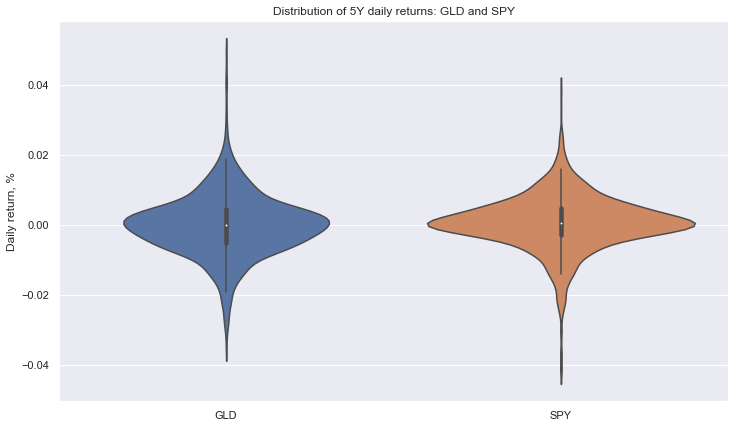

In [6]:
plt.figure(figsize=(12,7))

ax = sns.violinplot(data=returns)

ax.set_title('Distribution of 5Y daily returns: GLD and SPY')
ax.set_ylabel('Daily return, %');

## Simple correlation
We plot the daily returns for both securities and calculate the correlation coefficient between both to see if we can spot a relationship.

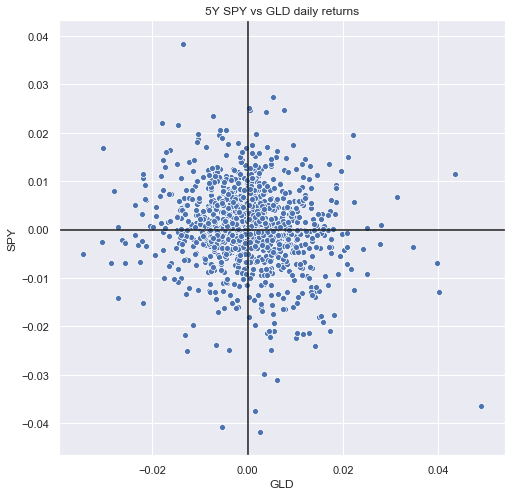

In [7]:
plt.figure(figsize=(8,8))

ax = sns.scatterplot(x=returns.GLD, y=returns.SPY)

plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')

ax.set_title('5Y SPY vs GLD daily returns');

Although the correlation coefficient is negative at -.1316 (indicating an inverse relationship, not causality) the relationship is very weak, which is confirmed by the scatter plot above.

In [8]:
returns.corr()

,GLD,SPY
GLD,1.000000,-0.131626
SPY,-0.131626,1.000000


## Rolling correlation
To get a better idea of how correlation has evolved over time, we will plot a standard 100D and 200D rolling-correlations for gold versus the S&P 500. We first calculate the 100D correlation.

In [9]:
returns_corr_100D = returns.rolling(100).corr().unstack().GLD.SPY
returns_corr_100D.tail(10)

date
2018-08-13    0.012426
2018-08-14   -0.000950
2018-08-15    0.102516
2018-08-16    0.066653
2018-08-17    0.053105
2018-08-20    0.043126
2018-08-21    0.040318
2018-08-22    0.124707
2018-08-23    0.153499
2018-08-24    0.166459
Name: SPY, dtype: float64

We repeat the same using a 200-day rolling window instead.

In [10]:
returns_corr_200D = returns.rolling(200).corr().unstack().GLD.SPY

To see how the correlation between gold and the market evolved over time, we plot the data.

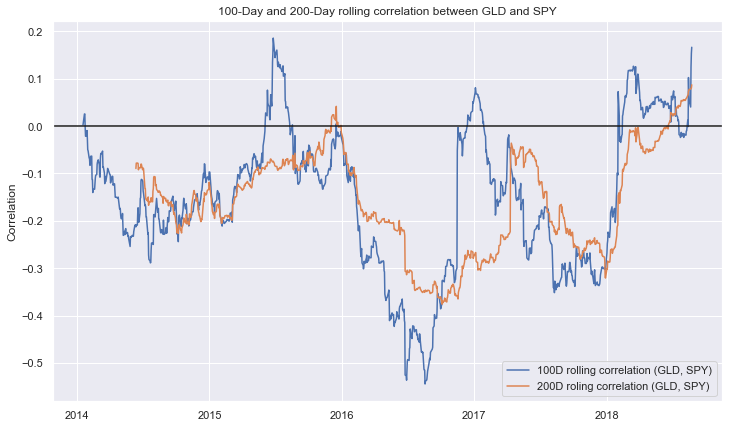

In [11]:
plt.figure(figsize=(12,7))

ax = sns.lineplot(x=returns_corr_100D.index, y=returns_corr_100D.values)
ax = sns.lineplot(x=returns_corr_200D.index, y=returns_corr_200D.values)

plt.axhline(y=0, color='k')

ax.set_title('100-Day and 200-Day rolling correlation between GLD and SPY')
ax.legend(['100D rolling correlation (GLD, SPY)', '200D roling correlation (GLD, SPY)'],
         loc='lower right')
ax.set_ylabel('Correlation')
ax.set_xlabel('');

Over the study period, we can clearly see that the correlation between both securities is not constant. For the 100-Day rolling window for instance, the correlation oscilates between -0.45 and 0.18 with the range being 0.73

In [14]:
print(returns_corr_100D.describe())
print(f'\nRange: {returns_corr_100D.max() - returns_corr_100D.min():.3f}')

count    1160.000000
mean       -0.152845
std         0.148959
min        -0.544452
25%        -0.262328
50%        -0.150664
75%        -0.049950
max         0.185870
Name: SPY, dtype: float64

Range: 0.730


## Beta
We claculate the beta in order to test GLD's sensitivity (volatility) in response to movements in SPY. This is done by first deriving the covariance between GLD and SPY, and then dividing it by the variance of GLD.

In [15]:
GLD_var = np.var(GLD_returns)
print('Gold variance:', GLD_var)

Gold variance: 7.793185485047561e-05


In [16]:
GLD_SPY_cov = np.cov(returns.GLD, returns.SPY)[0][1]
print('Gold and S&P 500 covariance:', GLD_SPY_cov)

Gold and S&P 500 covariance: -9.026557365910513e-06


The result is a beta of -.0116 indicating that the sensitivity of the returns of gold moved inversely to the market, given the past 5 years of data.

In [17]:
GLD_beta = GLD_SPY_cov / GLD_var
print(f'Gold beta to SPY: {GLD_beta:.3f}')

Gold beta to SPY: -0.116


To see how the beta changes when using different study periods, we define a function allowing us to do just that.

In [18]:
def calculate_beta(data, target, benchmark, timeframes):
    """Calculate beta given a target security and a benchmark over multiple time periods."""
    betas = {}
    
    for days in timeframes:
        variance = np.var(data[days:][target])
        covariance = np.cov(data[days:][target], data[days:][benchmark])[0][1]
        beta = covariance / variance
        
        timeframe = str(-days) + 'D'
        betas[timeframe] = beta
    
    df = pd.DataFrame.from_dict(betas, orient='index', columns=['beta'])
    
    return df

We can see that the 6M and 1Y betas are positive (0.1 and 0.06 respectively). However, the 2Y, 3Y, 4Y and 5Y betas for gold are negative.

In [19]:
betas_GLD = calculate_beta(returns, 'GLD', 'SPY', timeframes=[-126, -252, -504, -756, -1008, -1260])
betas_GLD

,beta
126D,0.101823
252D,0.060490
504D,-0.013324
756D,-0.160488
1008D,-0.131047
1260D,-0.115826


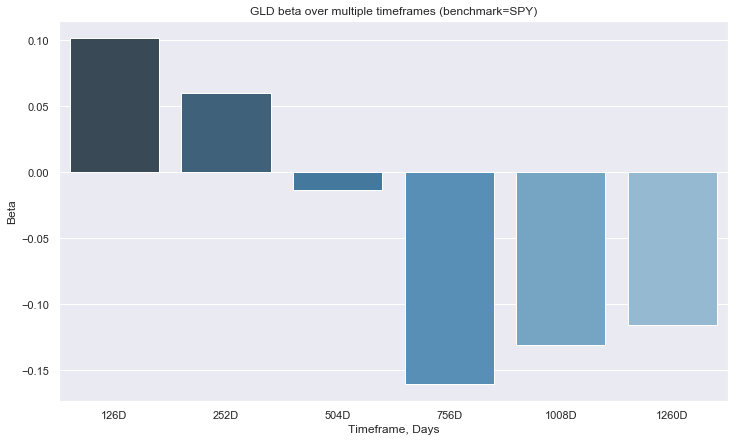

In [20]:
plt.figure(figsize=(12,7))

ax = sns.barplot(x=betas_GLD.index, y=betas_GLD.beta, palette='Blues_d')

ax.set_title('GLD beta over multiple timeframes (benchmark=SPY)')
ax.set_ylabel('Beta')
ax.set_xlabel('Timeframe, Days');

## Conclusion
This short empirical analysis shows that there is some evidence to support the notion that gold is negatively correlated to the S&P 500. However, when we look over multiple time periods, we see that the rolling correlation between both securities oscilates and can be quite volatile. This is confirmed by the betas calculated above which show that over longer periods of time (2-5 years) the coefficient is negative. For shorter time periods (6 months to 1 year) we observe the opposite however. 

As a result, investors looking to hold gold for downside market protection should be aware that the relationship between gold and the S&P 500 is not constant and may change rapidly.